# Recurrent Neural Network
 
Up to now we've used neural networks to classify static images. Now we will be studying <a href='https://en.wikipedia.org/wiki/Recurrent_neural_network'>Recurrent Neural Networks</a> (RNNs) which is specialized for time series data or text data, where previous affects the next.

The basic model of a single RNN unit is represented as:

$$ \mathbf{h_t} = f(\mathbf{W}_{x}\mathbf{x}_t + \mathbf{W}_{h}\mathbf{h}_{t-1} + \mathbf{b}) $$

Where:
- $h$ is the hidden size, and
- $\mathbf{h}_t$ $\in (h, )$ is the hidden state at time $t$ ,
- $\mathbf{x}_t$ $\in (n, )$ is the input at time $t$,
- $\mathbf{W}_{x}$ $\in (h, n)$ is the weight matrix for inputs to hidden layer,
- $\mathbf{W}_{h}$ $\in (h, h)$ is the weight matrix for hidden layer to hidden layer,
- $\mathbf{b}$ $\in (h, )$ is the hidden bias ,
- $f$ is the activation function.

## Predict Apple Stock using LSTM

Here we will be using 30 days in the past to predict the next 1 day.

To do so, we will split the last 15 days as test set, where we will use our model to slowly predict day by day, until we reached the 15 days.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
df = pd.read_csv("data/appl_1980_2014.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
1,2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2,2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
3,2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
4,2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


In [3]:
#make sure your data is of actually date format
# df.info()
df.Date = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8465 non-null   datetime64[ns]
 1   Open       8465 non-null   float64       
 2   High       8465 non-null   float64       
 3   Low        8465 non-null   float64       
 4   Close      8465 non-null   float64       
 5   Volume     8465 non-null   int64         
 6   Adj Close  8465 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 463.1 KB


### Choose the timeframe

In [4]:
# df.Date.dt.year.unique()
cond = (df.Date.dt.year > 2009) & (df.Date.dt.year < 2014)
df = df[cond]
df.Date.dt.year.unique()

array([2013, 2012, 2011, 2010])

### Set data as index

In [5]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2013-12-31', '2013-12-30', '2013-12-27', '2013-12-26',
               '2013-12-24', '2013-12-23', '2013-12-20', '2013-12-19',
               '2013-12-18', '2013-12-17',
               ...
               '2010-01-15', '2010-01-14', '2010-01-13', '2010-01-12',
               '2010-01-11', '2010-01-08', '2010-01-07', '2010-01-06',
               '2010-01-05', '2010-01-04'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)

In [6]:
df.sort_index(ascending=True, inplace=True)

In [7]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,123432400,29.22
2010-01-05,214.60,215.59,213.25,214.38,150476200,29.27
2010-01-06,214.38,215.23,210.75,210.97,138040000,28.81
2010-01-07,211.75,212.00,209.05,210.58,119282800,28.75
2010-01-08,210.30,212.00,209.06,211.98,111902700,28.94


## 2. EDA

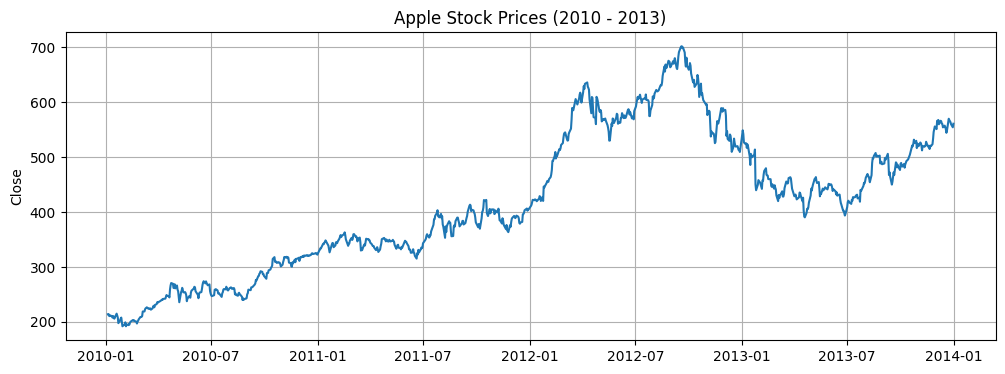

In [8]:
#plot the apple stocks
plt.figure(figsize=(12, 4))
plt.title('Apple Stock Prices (2010 - 2013)')
plt.ylabel('Close')
plt.grid()
plt.plot(df.Close)

## 3. Train test split

Here we will use the last 30 days of the training set to predict the next day.  Then we will autoregressively fill the next days until we reached 15 days.

In [9]:
y = df['Close'].values.astype('float')
train_set = y[:-15]
test_set  = y[-15:]

In [10]:
type(train_set)

numpy.ndarray

## 4. Normalization

We don't do standardization because mean is wrong.  Normalization - 0 to 1.

In [11]:
train_set.shape

(991,)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [13]:
train_set_norm.min(), train_set_norm.max()

(-0.9999999999999999, 1.0)

## 5. Prepare train set

When working with LSTM models, we start by dividing the training sequence into a series of overlapping "windows". Each window consists of a connected string of samples. The label used for comparison is equal to the next value in the sequence. In this way our network learns what value should follow a given pattern of preceding values. Note: although the LSTM layer produces a prediction for each sample in the window, we only care about the last one.

For example, say we have a series of 15 records, and a window size of 5. We feed $[x_1,..,x_5]$ into the model, and compare the prediction to $x_6$. Then we backprop, update parameters, and feed $[x_2,..,x_6]$ into the model. We compare the new output to $x_7$ and so forth up to $[x_{10},..,x_{14}]$.

To simplify matters, we'll define a function called `create_data` that builds a list of `(seq, label)` tuples. Windows overlap, so the first tuple might contain $([x_1,..,x_5],[x_6])$, the second would have $([x_2,..,x_6],[x_7])$, etc. 

Here $k$ is the width of the window. Due to the overlap, we'll have a total number of <tt>(seq, label)</tt> tuples equal to $\textrm{len}(series)-k$

In [14]:
#convert np to tensor
train_set_norm = torch.FloatTensor(train_set_norm).view(-1)
train_set_norm.shape

#define window size
ws = 30 #use 30 days in the past to predict the next day

#define function to create training set (ws days -> 1 day)
def create_data(seq, label):
    out = []
    #array to hold the out
    #i runs from 0 to (991 - 30)
    for i in range(seq.shape[0] - label):
        x = seq[i:i+label]          # 30 days in the past
        y = seq[i+label:i+label+1]  # next day
        out.append((x, y))
    return out

chaky_data = create_data(train_set_norm, ws)


In [15]:
chaky_data[0]

(tensor([-0.9139, -0.9124, -0.9258, -0.9273, -0.9219, -0.9292, -0.9386, -0.9271,
         -0.9318, -0.9456, -0.9099, -0.9228, -0.9372, -0.9776, -0.9568, -0.9455,
         -0.9379, -0.9716, -1.0000, -0.9895, -0.9851, -0.9718, -1.0000, -0.9866,
         -0.9919, -0.9838, -0.9880, -0.9740, -0.9673, -0.9555]),
 tensor([-0.9588]))

## 6. Neural Network

A variant of RNN called LSTM, which is much more powerful.

Our model will have one LSTM layer with an input size of 1 and a hidden size of 50, followed by a fully-connected layer to reduce the output to the prediction size of 1.<br>

<div class="alert alert-info"><strong>NOTE:</strong> You will often see the terms `input_dim` and `hidden_dim` used in place of `input_size` and `hidden_size`. They mean the same thing. We'll stick to `input_size` and `hidden_size` to stay consistent with PyTorch's built-in keywords.</div>

### Example

In [16]:
sample, target = chaky_data[0]

In [17]:
sample.shape  #30 samples in a time series

torch.Size([30])

In [18]:
target.shape #this is the 31th number after the 30 samples

torch.Size([1])

In [19]:
sample_reshape = sample.reshape(sample.shape[0], 1, -1)  #(1, 30)

In [20]:
lstm = nn.LSTM(1, 50)

In [21]:
out, hidden = lstm(sample_reshape)  #hidden has both h and c

In [22]:
out.shape #(length, batch size, hidden size)

torch.Size([30, 1, 50])

In [23]:
hidden[0].shape #(num layer, batch size, hidden size)

torch.Size([1, 1, 50])

In [24]:
# assert out[-1] == hidden[0]

In [25]:
out = out.view(len(out), -1)
out.shape

torch.Size([30, 50])

In [26]:
linear_layer = nn.Linear(50, 1)

In [27]:
out = linear_layer(out)
out.shape

torch.Size([30, 1])

### Network

In [28]:
class chaky_RNN(nn.Module):
    def __init__(self, input_s = 1, hs = 50, output_size = 1):
        super().__init__()
        self.hs = hs
        self.lstm = nn.LSTM(input_s, hs)  #LSTM will automatically create W(s) for us
        self.linear = nn.Linear(hs, output_size)  #take output of LSTM, project to prediction
        
    def forward(self, input_):
        out, _ = self.lstm(input_.reshape(input_.shape[0], 1, -1)) #30, 1, 1
        out    = self.linear(out.view(len(input_), -1))  #30, 50
        return out[-1]

In [29]:
torch.manual_seed(999)
model = chaky_RNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651


## 7. Training

In [31]:
epochs = 100

for i in range(epochs):
    
    # tuple-unpack the chaky_data set
    for seq, y_train in chaky_data:  
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # print training result
    if i % 10 == 0:
        print(f'Epoch: {i:2} Loss: {loss.item():10.8f}')

Epoch:  0 Loss: 0.01146772
Epoch: 10 Loss: 0.00310122
Epoch: 20 Loss: 0.00189553
Epoch: 30 Loss: 0.00251244
Epoch: 40 Loss: 0.00078887
Epoch: 50 Loss: 0.00236669
Epoch: 60 Loss: 0.00226517
Epoch: 70 Loss: 0.00226556
Epoch: 80 Loss: 0.00318907
Epoch: 90 Loss: 0.00255545


## 8. Testing

In [32]:
preds = train_set_norm[-ws:].tolist()

model.eval()

for i in range(ws):
    seq = torch.FloatTensor(preds[-ws:])  #the reason is because we keep appending on this
    with torch.no_grad():
        yhat = model(seq)
        preds.append(yhat.item())

## 9. Plotting

In [33]:
np.array(preds[-ws:]).reshape(-1, 1).shape

(30, 1)

We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [34]:
#1. inverse the normalization
true_numbers = scaler.inverse_transform(np.array(preds[-ws:]).reshape(-1, 1))

In [35]:
#2. plot
x = df['Close'][-ws:].index

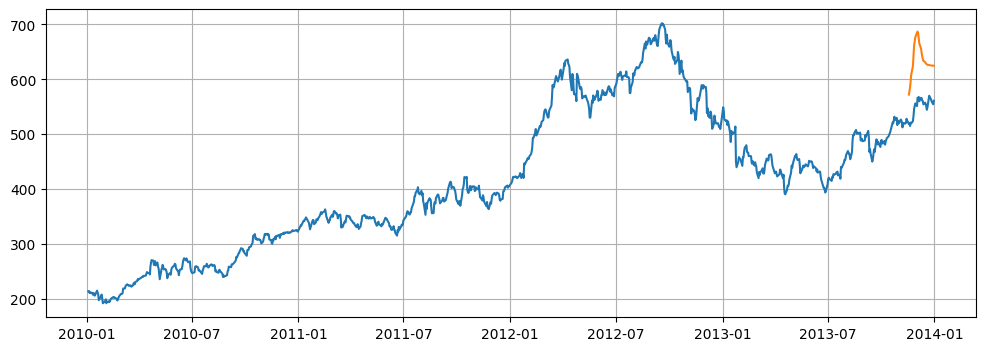

In [36]:
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(df['Close'])  #historical data
plt.plot(x, true_numbers)

## Workshop

1. What is RNN and what is the essence of this model?
2. In RNN, how many weights are there?  Which one is shared?  For example, if my sequence length is 100, how many matrix of weights I will have?  How about bias?
3. What is the shape of $\mathbf{x}_t$, $\mathbf{h}_t$, $\mathbf{W}_h$, $\mathbf{W}_x$, $\mathbf{b}$?
4. Given $\mathbf{x}_1$ of [[4], [3], [2], [1], [1]] as 5 samples in a time series data, $\mathbf{h}_0$ as [1, 2, 3, 4, 5], $\mathbf{W}_x$ as [[4, 3, -1, 2, 0]], $\mathbf{W}_h$ as $$\begin{bmatrix}
-3 & 2 & -1 & 4 & 0 \\
-1 & 1 & 0 & 2 & 0 \\
3 & -2 & 1 & 1 & 5 \\
-4 & 1 & -2 & 6 & -1 \\
-2 & 1 & -1 & 1 & 1
\end{bmatrix}$$, and $\mathbf{b}$ as [1, 1, 2, 2, 1], calculate $\mathbf{h}_1$, $\mathbf{h}_2$, and so on.  For simplicity, ignore the activation function.

1. Btw, in above code, what is the hidden size? What is the sequence length?